In [78]:
import pandas as pd
import joblib
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import accessible_space
from databallpy.visualize import plot_soccer_pitch, plot_tracking_data
from databallpy import get_saved_game
from IPython.display import display
import time

player_id = "home_25"
game_id = "J03WQQ"
parameters = "R_5-S_1-D_2-N_20"
provider = "IDSSE"
step = "step125"
top_n = 5
method= "random"
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 0)
titles=["DAS Originale Position", "DAS Optimierte Position"]
colors=["blue", "green"]

full_df = pd.read_csv("output/full_das.csv")
df_player = full_df[
    (full_df["player"] == player_id) &
    (full_df["game_id"] == game_id) &
    (full_df["parameters"] == parameters) &
    (full_df["step"] == step) &
    (full_df["method"] == method)
]

frame_scores_percentage = (
    df_player.groupby("frame")["DAS_potential_percentage"]
    .max()
    .sort_values(ascending=False)
)
frame_scores_absolute = (
    df_player.groupby("frame")["DAS_potential"]
    .max()
    .sort_values(ascending=False)
)

top_frames_percentage = frame_scores_percentage.index.to_list()
top_frame_percentage = top_frames_percentage[0]

top_frames_absolute = frame_scores_absolute.index.to_list()
top_frame_absolute = top_frames_absolute[0]

df_top_frames_all_methods = df_player[df_player["frame"].isin(top_frames_percentage)]


In [80]:
def plot_frame(df, frame_id, player_id, game_id, provider):
    df_frame = df[(df["frame"] == frame_id)].reset_index()
    row = df_frame.iloc[0]
    move_x = row["move_x"]
    move_y = row["move_y"]
    game = load_game_data(provider, game_id)
    idx = game.tracking_data[game.tracking_data["frame"]==frame_id].index[0]
    
    add_optimized_position_to_game(game, player_id, move_x, move_y, idx, frame_id)
    pitch_results = []
    pitch_indices = []
    frame_indices = []
    
    pitch_result, pitch_index, frame_index = load_pitch_result(game_id, frame_id)
    pitch_results.append(pitch_result)
    pitch_indices.append(pitch_index)
    frame_indices.append(frame_index)
    
    new_frame_id = f"{frame_id}_{player_id}_{move_x:.2f}_{move_y:.2f}"
    
    pitch_result_new, pitch_index_new, frame_index_new = load_pitch_result(game_id, new_frame_id, origin=False, player_id=player_id)
    pitch_results.append(pitch_result_new)
    pitch_indices.append(pitch_index_new)
    frame_indices.append(frame_index_new)
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 16))
    for title, ax, pr, pi, c, fi in zip(titles, axes, pitch_results, pitch_indices, colors, frame_indices):
        plot_soccer_pitch(pitch_color="white", fig=fig, ax=ax)
        plot_tracking_data(
            game,
            idx,
            fig=fig,
            ax=ax,
            title=title,
            team_colors=["red", "brown"],
            variable_of_interest=pr.das.iloc[fi],
            #variable_of_interest=frame_id
        )
        highlight_player(ax, game, idx, player_id, color="blue")
        highlight_player(ax, game, idx, "home_99", color="green")
        plt.sca(ax)
        accessible_space.plot_expected_completion_surface(pr.dangerous_result, frame_index=pi, color=c)
        
    return pitch_results, pitch_indices

    
def load_game_data(provider, game_id):
    if provider == "metrica":
        path = f"../datasets/"
    else:
        path = f"../datasets/{provider}"
    game = get_saved_game(name=game_id, path=path)
    return game

def prep_game_data(game, max_velocity=25):
    col_ids = game.get_column_ids() + ["ball"]
    game.tracking_data.add_velocity(column_ids=col_ids, max_velocity=max_velocity)
    game.synchronise_tracking_and_event_data()
    game.tracking_data.add_individual_player_possession()

def add_optimized_position_to_game(game, player_id, move_x, move_y, idx, frame):
    opt_player_id = f"{player_id.rsplit('_')[0]}_99"
    x_col = f"{opt_player_id}_x"
    y_col = f"{opt_player_id}_y"
    
    orig_x = game.tracking_data.at[idx, f"{player_id}_x"]
    orig_y = game.tracking_data.at[idx, f"{player_id}_y"]
    x = orig_x + move_x
    y = orig_y + move_y
    
    if x_col not in game.tracking_data.columns:
        game.tracking_data[x_col] = np.nan
        game.tracking_data[y_col] = np.nan
    
    game.tracking_data.at[idx, x_col] = x
    game.tracking_data.at[idx, y_col] = y
    
    if "OPT_99" not in game.home_players["id"].to_list():
        player = {
            'id': "OPT_99",
            'full_name': "Optimised Player",
            'shirt_num': 99, 
            'position': "unspecified",
            'start_frame': -999,
            'end_frame': -999,
            'starter': False
        }
        game.home_players = pd.concat([game.home_players, pd.DataFrame([player])])
        
def highlight_player(ax, game, idx, player_col_id, color="black", radius=1.0):
    x = game.tracking_data.loc[idx, f"{player_col_id}_x"]
    y = game.tracking_data.loc[idx, f"{player_col_id}_y"]
    
    if pd.isna(x) or pd.isna(y):
        return
    
    circle = plt.Circle((x,y), radius=radius, fill=False, lw=2.5, zorder=3.5, color=color)
    ax.add_patch(circle)
    
def load_pitch_result(game_id, frame_id, step="step125", origin=True, player_id=None, method="random", params="R_5-S_1-D_2-N_20"):
    if origin:
        path = Path(f"../cache_new/pitch_results/{game_id}_{step}.pkl")
        if path.exists():
            pitch_result = joblib.load(path)
        else:
            display("Error")
            
        frame_list_path = Path(f"../cache_new/pitch_results/frame_list_{game_id}_{step}.csv")
        if frame_list_path.exists():
            frame_list = np.loadtxt(frame_list_path, delimiter=",", dtype=int)
            np.sort(frame_list)
        else:
            display("Error")
        frame_idx = int(np.argmax(frame_list == frame_id))
        pitch_index = pitch_result.frame_index.iloc[frame_idx]
        

    else:
        path = Path(f"../cache_new/optimization/{game_id}/{player_id}/{step}/{method}/{params}/pitch_result.pkl")
        if path.exists():
            pitch_result = joblib.load(path)
        else:
            display("Error")
        
        frame_list_path =Path(f"../cache_new/optimization/{game_id}/{player_id}/{step}/{method}/{params}/frame_list.csv")
        if frame_list_path.exists():
            frame_list = np.loadtxt(frame_list_path, delimiter=",", dtype=str)
        else:
            display("Error")
        
        # if int(np.argmax(frame_list == frame_id)) > 20553:
        #     frame_idx = (23 * 20553) + ((int(np.argmax(frame_list == frame_id)) - 20553) * 22)
        #     display("IF")
        # else:
        #     frame_idx = int(np.argmax(frame_list == frame_id)) * 23
        #     display("ELSE")
        
        frame_idx = int(np.argmax(frame_list == frame_id))
        pitch_index = pitch_result.frame_index.iloc[frame_idx]
        # display(frame_idx)
        # display(pitch_index)

    return pitch_result, pitch_index, frame_idx
    

27186

np.int64(3086)

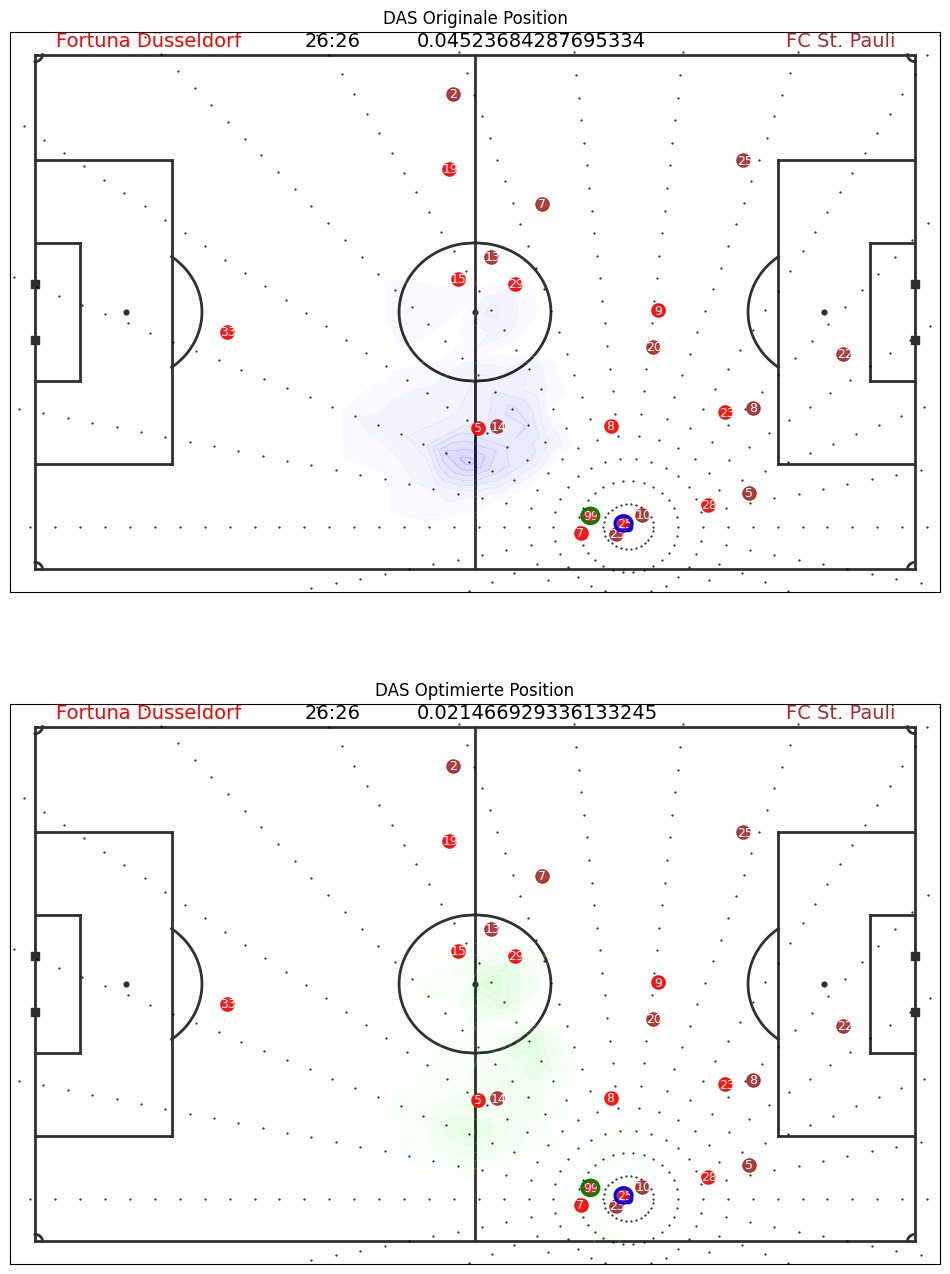

In [ ]:
pitch_results, pitch_indices = plot_frame(df_top_frames_all_methods, top_frame_percentage, player_id, game_id, provider)

55890

np.int64(344)

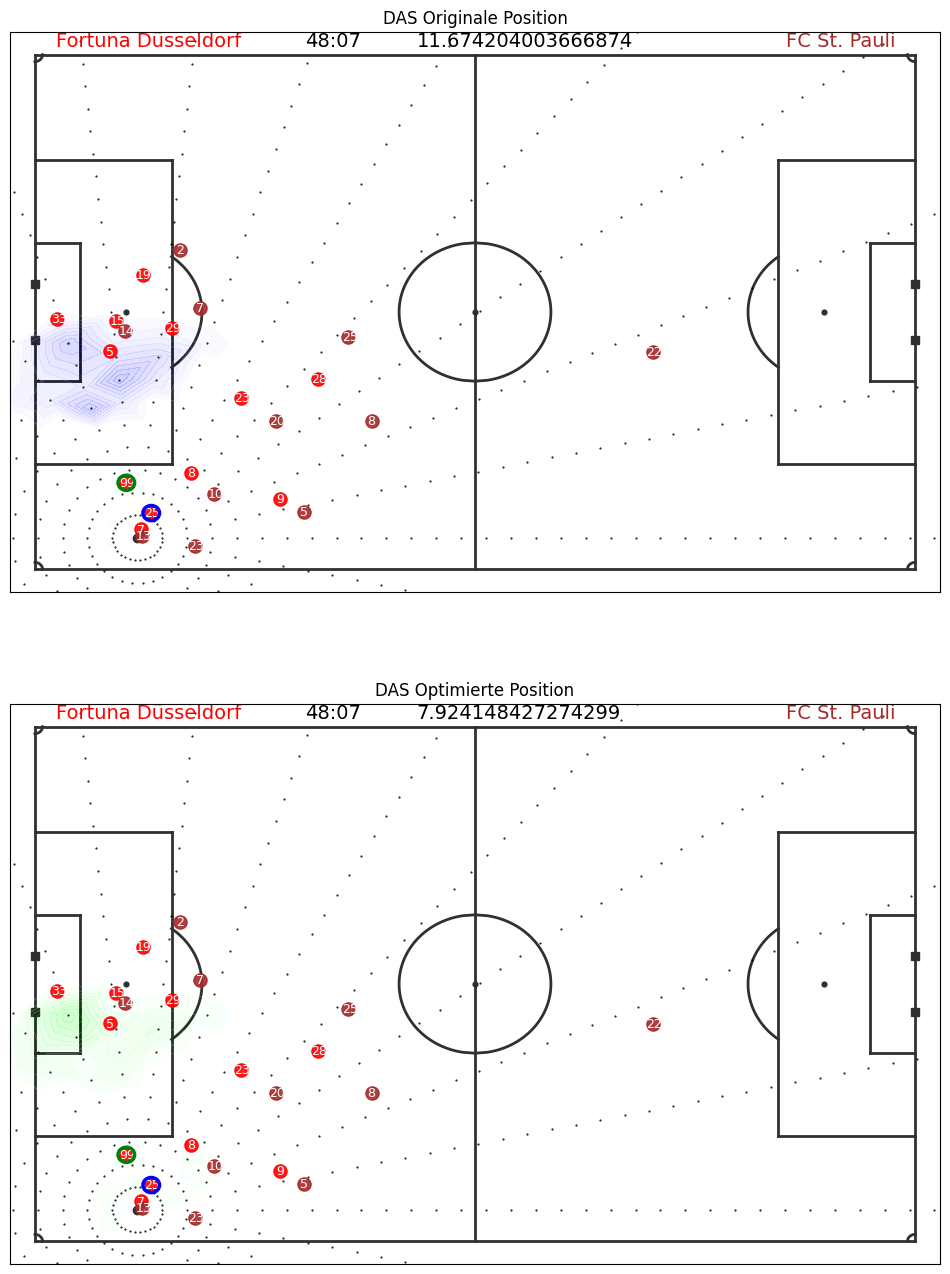

In [79]:
pitch_results, pitch_indices = plot_frame(df_top_frames_all_methods, top_frame_absolute, player_id, game_id, provider)

In [ ]:
# pitch_results, pitch_indices = plot_frame(df_top_frames_all_methods, second_frame, player_id, game_id, provider)

In [ ]:
# for i, (pr, pi) in enumerate(zip(pitch_results, pitch_indices)):
#     display(pr.dangerous_result.attack_poss_density[pi].shape)
#     np.savetxt(f"../../{i}_gridcontrol.csv", pr.dangerous_result.attack_poss_density[pi], delimiter=",")

In [ ]:
# pitch_result = pitch_results[1]
# frame_index = pitch_result.frame_index
# counts = frame_index.value_counts()
# summary = counts.value_counts()
# display(summary)
# display(len(frame_index.unique()))

count
23    11339
22     4457
Name: count, dtype: int64

15796